# Entrenamiento internet

In [1]:
import os

# Dataset
SOURCE_LANGUAGE = "en"
TARGET_LANGUAGE = "es"
SUBSET = False
PERCENT_SUBSET = 0.01

# Train
LR = 1e-5
EPOCHS = 1000
GPUS = 1
GPU_NUMBER = 0
if GPUS > 1:
    BS = 56
else:
    if SUBSET:
        BS = 128
    else:
        BS = 1024
print(f"BS: {BS}")
LR_SCHEDULER = False
SAVE_BEST_MODEL = True
STOP_AT_TIME = False
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='nltk')

# Model
MODEL_PATH = f"model"
if os.path.exists(MODEL_PATH):
    files = os.listdir(MODEL_PATH)
    model_files = [file for file in files if "transformer" in file]
    if len(model_files) > 0:
        name = model_files[0].split(".")[0]
        STEP0 = int(name.split("_")[-1])
        EPOCH0 = int(name.split("_")[-2])
    else:
        EPOCH0 = 0
        STEP0 = 0
else:
    EPOCH0 = 0
    STEP0 = 0
print(f"EPOCH0: {EPOCH0}, STEP0: {STEP0}")
DIM_EMBEDDING = 512
NUM_HEADS = 8
NUM_LAYERS = 6
DROPOUT = 0.1
LABEL_SMOOTHING = 0.1

# Tokenizers
TOKENIZERS_PATH = f"tokenizers"
if not os.path.exists(TOKENIZERS_PATH):
    os.makedirs(TOKENIZERS_PATH)
UNKNOWN_TOKEN = "[UNK]"
PADDING_TOKEN = "[PAD]"
START_OF_SEQUENCE = "[SOS]"
END_OF_SEQUENCE = "[EOS]"

BS: 1024
EPOCH0: 0, STEP0: 0


In [2]:
# TODOs
# TODO: Leer The Annotated Transformer --> https://nlp.seas.harvard.edu/annotated-transformer/
# TODO: Ajustar bien los parámetros del LR scheduler
# TODO: Implementar STOP_AT_TIME
# TODO: Añadir enlace a colab

## Carga de los datos

Cargamos el dataset

In [3]:
from datasets import load_from_disk

path_train = "data/opus100_train_croped_3_20"
path_val = "data/opus100_val_croped_3_20"
path_test = "data/opus100_test_croped_3_20"

dataset_raw_train = load_from_disk(path_train)
dataset_raw_val = load_from_disk(path_val)
dataset_raw_test = load_from_disk(path_test)

if SUBSET:
    len_dataset_train = len(dataset_raw_train)
    len_dataset_val = len(dataset_raw_val)
    len_dataset_test = len(dataset_raw_test)
    len_subset_train = int(len_dataset_train * PERCENT_SUBSET)
    len_subset_val = int(len_dataset_val * PERCENT_SUBSET)
    len_subset_test = int(len_dataset_test * PERCENT_SUBSET)
    dataset_raw_train = dataset_raw_train.select(range(len_subset_train))
    dataset_raw_val = dataset_raw_val.select(range(len_subset_val))
    dataset_raw_test = dataset_raw_test.select(range(len_subset_test))

len(dataset_raw_train), len(dataset_raw_val), len(dataset_raw_test)

(728561, 1458, 1444)

Vamos a ver cómo es el dataset

In [4]:
dataset_raw_train

Dataset({
    features: ['translation'],
    num_rows: 728561
})

Vemos que es un objeto con 1000000 de filas y una `feature` llamada `translation`

Vamos a ver la feature `translation`

In [5]:
dataset_raw_train['translation']

[{'en': "It was the asbestos in here, that's what did it!",
  'es': 'Fueron los asbestos aquí. ¡Eso es lo que ocurrió!'},
 {'en': "I'm out of here.", 'es': 'Me voy de aquí.'},
 {'en': 'One time, I swear I pooped out a stick of chalk.',
  'es': 'Una vez, juro que cagué una barra de tiza.'},
 {'en': 'And I will move, do you understand me?',
  'es': 'Y prefiero mudarme, ¿Entiendes?'},
 {'en': '- Thank you, my lord.', 'es': '- Gracias.'},
 {'en': 'You have to help me.', 'es': 'Debes ayudarme.'},
 {'en': 'Fuck this!', 'es': '¡Por la mierda!'},
 {'en': 'The safety and efficacy of MIRCERA therapy in other indications has not been established.',
  'es': 'No se ha establecido la seguridad y eficacia del tratamiento con MIRCERA en otras indicaciones.'},
 {'en': 'You can stay if you want.',
  'es': 'Así lo decidí, pueden quedarse si quieren.'},
 {'en': "- I'm not stupid.", 'es': '- Yo no soy estúpido.'},
 {'en': 'Sorry, a weird gas bubble for a sec.',
  'es': 'Perdón, he tenido una burbuja de gas

Vemos que es una lista, vamos a ver el primer elemento

In [6]:
dataset_raw_train[0]['translation']

{'en': "It was the asbestos in here, that's what did it!",
 'es': 'Fueron los asbestos aquí. ¡Eso es lo que ocurrió!'}

Vemos que es un diccionario con la frase en el idioma original y la traducción

Vamos a ver una frase en cada idioma

In [7]:
dataset_raw_train[0]['translation'][SOURCE_LANGUAGE]

"It was the asbestos in here, that's what did it!"

In [8]:
dataset_raw_train[0]['translation'][TARGET_LANGUAGE]

'Fueron los asbestos aquí. ¡Eso es lo que ocurrió!'

## Device

In [9]:
import torch

if torch.cuda.device_count() > 1 and GPUS > 1:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {torch.cuda.device_count()} GPUs")
else:
    if torch.cuda.is_available():
        device = torch.device(f"cuda:{GPU_NUMBER}")
        print(f"Using GPU {GPU_NUMBER}")
    else:
        device = torch.device("cpu")
        print("Using CPU")

Using GPU 0


## Entrenamiento de los tokenizers

Vamos a entrenar un tokenizer para cada idioma. Podríamos utilizar uno ya preentrenado, pero a veces entrenar uno propio puede dar mejores resultados.

In [10]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

In [11]:
import tqdm

def get_all_sentences(dataset, languaje):
    all_sentences = []
    bar = tqdm.tqdm(range(len(dataset)))
    for i in bar:
        all_sentences.append(dataset[i]['translation'][languaje])
    return all_sentences

Entrenamos el tokenizer para el idioma original

In [12]:
tokenizer_source_path = f"{TOKENIZERS_PATH}/tokenizer_{SOURCE_LANGUAGE}.json"

if not os.path.exists(tokenizer_source_path):
    print(f"Training source tokenizer")
    tokenizer_source = Tokenizer(WordLevel(unk_token=UNKNOWN_TOKEN))
    tokenizer_source.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=[UNKNOWN_TOKEN, PADDING_TOKEN, START_OF_SEQUENCE, END_OF_SEQUENCE])
    all_sentences = get_all_sentences(dataset_raw_train, SOURCE_LANGUAGE)
    tokenizer_source.train_from_iterator(all_sentences, trainer)
    tokenizer_source.save(tokenizer_source_path)
else:
    print(f"Loading source tokenizer from {tokenizer_source_path}")
    tokenizer_source = Tokenizer.from_file(tokenizer_source_path)

Loading source tokenizer from tokenizers/tokenizer_en.json


Vamos a ver cómo es el tokenizer

In [13]:
with open(tokenizer_source_path, 'r') as file:
    for i in range(100):
        line = file.readline()
        if line == "\n":
            continue
        print(line, end="")

{
  "version": "1.0",
  "truncation": null,
  "padding": null,
  "added_tokens": [
    {
      "id": 0,
      "content": "[UNK]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 1,
      "content": "[PAD]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 2,
      "content": "[SOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 3,
      "content": "[EOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    }
  ],
  "normalizer": null,
  "pre_tokenizer": {
    "type": "Whitespace"
  },
  "post_processor": null,
  "decoder": null,
  "model": {
    "type": "WordLevel",
    "vocab": {
      "[UNK]": 0,
      "[PAD]": 1

Entrenamos el tokenizer para el idioma traducido

In [14]:
tokenizer_target_path = f"{TOKENIZERS_PATH}/tokenizer_{TARGET_LANGUAGE}.json"

if not os.path.exists(tokenizer_target_path):
    print(f"Training target tokenizer")
    tokenizer_target = Tokenizer(WordLevel(unk_token=UNKNOWN_TOKEN))
    tokenizer_target.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=[UNKNOWN_TOKEN, PADDING_TOKEN, START_OF_SEQUENCE, END_OF_SEQUENCE])
    all_sentences = get_all_sentences(dataset_raw_train)
    tokenizer_target.train_from_iterator(all_sentences, trainer)
    tokenizer_target.save(tokenizer_target_path)
else:
    print(f"Loading target tokenizer from {tokenizer_target_path}")
    tokenizer_target = Tokenizer.from_file(tokenizer_target_path)

Loading target tokenizer from tokenizers/tokenizer_es.json


Vamos a ver cómo es el tokenizer

In [15]:
with open(tokenizer_target_path, 'r') as file:
    for i in range(100):
        line = file.readline()
        if line == "\n":
            continue
        print(line, end="")

{
  "version": "1.0",
  "truncation": null,
  "padding": null,
  "added_tokens": [
    {
      "id": 0,
      "content": "[UNK]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 1,
      "content": "[PAD]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 2,
      "content": "[SOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 3,
      "content": "[EOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    }
  ],
  "normalizer": null,
  "pre_tokenizer": {
    "type": "Whitespace"
  },
  "post_processor": null,
  "decoder": null,
  "model": {
    "type": "WordLevel",
    "vocab": {
      "[UNK]": 0,
      "[PAD]": 1

## Obtención de la lóngitud máxima de las secuencias

In [16]:
max_source_sequence_length = 0
max_target_sequence_length = 0

for i in range(len(dataset_raw_train)):
    source_sequence_length = len(tokenizer_source.encode(dataset_raw_train[i]['translation'][SOURCE_LANGUAGE]).ids)
    target_sequence_length = len(tokenizer_target.encode(dataset_raw_train[i]['translation'][TARGET_LANGUAGE]).ids)
    if source_sequence_length > max_source_sequence_length:
        max_source_sequence_length = source_sequence_length
    if target_sequence_length > max_target_sequence_length:
        max_target_sequence_length = target_sequence_length

max_sequence_len = max(max_source_sequence_length, max_target_sequence_length)
max_sequence_len += 2   # Add 2 for the start and end of sequence tokens

print(f"Max source sequence length: {max_source_sequence_length}")
print(f"Max target sequence length: {max_target_sequence_length}")
print(f"Max sequence length: {max_sequence_len}")

Max source sequence length: 20
Max target sequence length: 20
Max sequence length: 22


## Datasets

### Mask

In [17]:
def create_mask(sequence_len):
    if GPUS > 1:
        mask = torch.tril(torch.ones((torch.cuda.device_count(), sequence_len, sequence_len)))
    else:
        mask = torch.tril(torch.ones((1, sequence_len, sequence_len)))
    return mask

### Dataset class

In [18]:
import torch
from torch.utils.data import Dataset

class BilingualDataset(Dataset):
    def __init__(self, dataset, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, max_seq_len) -> None:
        super().__init__()
        
        self.max_seq_len = max_seq_len
        self.dataset = dataset
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        
        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id(START_OF_SEQUENCE)], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id(END_OF_SEQUENCE)], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id(PADDING_TOKEN)], dtype=torch.int64)
        self.unk_token = torch.tensor([tokenizer_tgt.token_to_id(UNKNOWN_TOKEN)], dtype=torch.int64)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        # Getting the source and target texts from the dataset
        src_target_pair = self.dataset[index]['translation']
        src_text = src_target_pair[self.src_lang]
        tgt_text = src_target_pair[self.tgt_lang]
        
        # Tokenizing source and target texts 
        encoder_input_tokens = self.tokenizer_src.encode(src_text).ids
        decoder_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids
        
        # Computing how many padding tokens need to be added to the tokenized texts 
        encoder_num_padding_tokens = self.max_seq_len - len(encoder_input_tokens) - 2 # Subtracting the two '[EOS]' and '[SOS]' special tokens
        decoder_num_padding_tokens = self.max_seq_len - len(decoder_input_tokens) - 1 # Subtracting the '[SOS]' special token
        
        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if encoder_num_padding_tokens < 0 or decoder_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')
         
        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token
                torch.tensor(encoder_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
                self.eos_token, # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * encoder_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )
        
        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token 
                torch.tensor(decoder_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                torch.tensor([self.pad_token] * decoder_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )
        
        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(decoder_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                self.eos_token, # Inserting the '[EOS]' token 
                torch.tensor([self.pad_token] * decoder_num_padding_tokens, dtype = torch.int64) # Adding padding tokens
            ]
        )
        
        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.max_seq_len
        assert decoder_input.size(0) == self.max_seq_len
        assert label.size(0) == self.max_seq_len

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input, 
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }


Veamos una muestra

In [19]:
from random import randint

sample_dataset = BilingualDataset(dataset_raw_train, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)
idx = randint(0, len(sample_dataset))
sample_dataset = sample_dataset[idx]

print(f"Encoder input shape: {sample_dataset['encoder_input'].shape}")
print(f"Decoder input shape: {sample_dataset['decoder_input'].shape}")
print(f"Label shape: {sample_dataset['label'].shape}")
print(f"Source text: {sample_dataset['src_text']}")
print(f"Target text: {sample_dataset['tgt_text']}")

Encoder input shape: torch.Size([22])
Decoder input shape: torch.Size([22])
Label shape: torch.Size([22])
Source text: It's called "downtime."
Target text: Se llama de "tiempo de inactividad".


### Split dataset

Ahora que vemos que está bien, creamos los datasets de entrenamiento y validación

In [20]:
print(f"Len train: {len(dataset_raw_train)}, len validation: {len(dataset_raw_val)}, len test: {len(dataset_raw_test)}")

Len train: 728561, len validation: 1458, len test: 1444


In [21]:
train_dataset = BilingualDataset(dataset_raw_train, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)
validation_dataset = BilingualDataset(dataset_raw_val, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)
test_dataset = BilingualDataset(dataset_raw_test, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)

## Dataloaders

In [22]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BS, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

Vamos a ver una muestra

In [23]:
batch = next(iter(train_dataloader))
type(batch)

dict

Como vemos la muestra es un diccionario, vamos a ver sus claves

In [24]:
batch.keys()

dict_keys(['encoder_input', 'decoder_input', 'label', 'src_text', 'tgt_text'])

Las claves son las salidas que habíamos definido en el dataset. Vamos a ver ahora cómo es cada una de las claves

In [25]:
batch['encoder_input'].shape, batch['decoder_input'].shape, batch['label'].shape, len(batch['src_text']), len(batch['tgt_text'])

(torch.Size([1024, 22]),
 torch.Size([1024, 22]),
 torch.Size([1024, 22]),
 1024,
 1024)

Cada una de las claves tiene tantas muestras como hemos definido en el batch size (`BS`). Vamos ahora a ver una de las muestras

In [26]:
idx = randint(0, BS)

print(f"Encoder input shape: {batch['encoder_input'][idx].shape}")
print(f"Decoder input shape: {batch['decoder_input'][idx].shape}")
print(f"Label shape: {batch['label'][idx].shape}")
print(f"Source text: {batch['src_text'][idx]}")
print(f"Target text: {batch['tgt_text'][idx]}")

Encoder input shape: torch.Size([22])
Decoder input shape: torch.Size([22])
Label shape: torch.Size([22])
Source text: "What are you up to down there?"
Target text: "¿Qué hacen ahí abajo?"


## Modelo

Volvemos a escribir todo el código del transformer y creamos un objeto de este

### Clases de bajo nivel

In [27]:
import torch
import torch.nn as nn
import torch.nn.init as init

class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(CustomLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        init.kaiming_uniform_(self.linear.weight, nonlinearity='relu')
        if self.linear.bias is not None:
            init.zeros_(self.linear.bias)
    
    def forward(self, x):
        return self.linear(x)

class CustomEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(CustomEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        init.xavier_uniform_(self.embedding.weight)
    
    def forward(self, x):
        return self.embedding(x)

class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = CustomEmbedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

class PositionalEncoding(nn.Module):
    def __init__(self, max_sequence_len, embedding_model_dim):
        super().__init__()
        self.embedding_dim = embedding_model_dim
        positional_encoding = torch.zeros(max_sequence_len, self.embedding_dim)
        for pos in range(max_sequence_len):
            for i in range(0, self.embedding_dim, 2):
                positional_encoding[pos, i]     = torch.sin(torch.tensor(pos / (10000 ** ((2 * i) / self.embedding_dim))))
                positional_encoding[pos, i + 1] = torch.cos(torch.tensor(pos / (10000 ** ((2 * (i+1)) / self.embedding_dim))))
        positional_encoding = positional_encoding.unsqueeze(0)
        self.register_buffer('positional_encoding', positional_encoding)

    def forward(self, x):
        x = x * torch.sqrt(torch.tensor(self.embedding_dim))
        sequence_len = x.size(1)
        x = x + self.positional_encoding[:,:sequence_len]
        return x

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dim_embedding):
        super().__init__()
        self.dim_embedding = dim_embedding
    
    def forward(self, query, key, value, mask=None):
        key_trasposed = key.transpose(-1,-2)
        product = torch.matmul(query, key_trasposed)
        scale = product / torch.sqrt(torch.tensor(self.dim_embedding))
        if mask is not None:
            scale = scale.masked_fill(mask == 0, float('-inf'))
        attention_matrix = torch.softmax(scale, dim=-1)
        output = torch.matmul(attention_matrix, value)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, dim_embedding):
        super().__init__()
        
        self.dim_embedding = dim_embedding
        self.dim_proyection = dim_embedding // heads
        self.heads = heads
        self.proyection_Q = CustomLinear(dim_embedding, dim_embedding)
        self.proyection_K = CustomLinear(dim_embedding, dim_embedding)
        self.proyection_V = CustomLinear(dim_embedding, dim_embedding)
        self.attention = CustomLinear(dim_embedding, dim_embedding)
        self.scaled_dot_product_attention = ScaledDotProductAttention(self.dim_proyection)
    
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        proyection_Q = self.proyection_Q(Q).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_K = self.proyection_K(K).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_V = self.proyection_V(V).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_Q = proyection_Q.transpose(1,2)
        proyection_K = proyection_K.transpose(1,2)
        proyection_V = proyection_V.transpose(1,2)
        scaled_dot_product_attention = self.scaled_dot_product_attention(proyection_Q, proyection_K, proyection_V, mask=mask)
        concat = scaled_dot_product_attention.transpose(1,2).contiguous().view(batch_size, -1, self.dim_embedding)
        output = self.attention(concat)
        return output

class AddAndNorm(nn.Module):
    def __init__(self, dim_embedding):
        super().__init__()
        self.normalization = nn.LayerNorm(dim_embedding)

    def forward(self, x, sublayer):
        return self.normalization(torch.add(x, sublayer))

class FeedForward(nn.Module):
    def __init__(self, dim_embedding, increment=4):
        super().__init__()
        self.feed_forward = nn.Sequential(
            CustomLinear(dim_embedding, dim_embedding*increment),
            nn.ReLU(),
            CustomLinear(dim_embedding*increment, dim_embedding)
        )
    
    def forward(self, x):
        x = self.feed_forward(x)
        return x

class Linear(nn.Module):
    def __init__(self, dim_embedding, vocab_size):
        super().__init__()
        self.linear = CustomLinear(dim_embedding, vocab_size)
        
    def forward(self, x):
        x = self.linear(x)
        return x

class Softmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.softmax(x)
        return x

class Dropout(torch.nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            return torch.nn.functional.dropout(x, p=self.p)
        else:
            return x


### Clases de medio nivel

In [28]:
class EncoderLayer(nn.Module):
    def __init__(self, heads, dim_embedding, prob_dropout=0.1):
        super().__init__()
        self.multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_1 = Dropout(prob_dropout)
        self.add_and_norm_1 = AddAndNorm(dim_embedding)
        self.feed_forward = FeedForward(dim_embedding)
        self.dropout_2 = Dropout(prob_dropout)
        self.add_and_norm_2 = AddAndNorm(dim_embedding)
    
    def forward(self, x):
        multi_head_attention = self.multi_head_attention(x, x, x)
        dropout1 = self.dropout_1(multi_head_attention)
        add_and_norm_1 = self.add_and_norm_1(x, dropout1)
        feed_forward = self.feed_forward(add_and_norm_1)
        dropout2 = self.dropout_2(feed_forward)
        add_and_norm_2 = self.add_and_norm_2(add_and_norm_1, dropout2)
        return add_and_norm_2

class Encoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, prob_dropout=0.1):
        super().__init__()
        self.encoder_layers = nn.ModuleList([EncoderLayer(heads, dim_embedding, prob_dropout) for _ in range(Nx)])
    
    def forward(self, x):
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, heads, dim_embedding, prob_dropout=0.1):
        super().__init__()
        self.masked_multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_1 = Dropout(prob_dropout)
        self.add_and_norm_1 = AddAndNorm(dim_embedding)
        self.encoder_decoder_multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_2 = Dropout(prob_dropout)
        self.add_and_norm_2 = AddAndNorm(dim_embedding)
        self.feed_forward = FeedForward(dim_embedding)
        self.dropout_3 = Dropout(prob_dropout)
        self.add_and_norm_3 = AddAndNorm(dim_embedding)
    
    def forward(self, x, encoder_output, mask=None):
        Q = x
        K = x
        V = x
        masked_multi_head_attention = self.masked_multi_head_attention(Q, K, V, mask=mask)
        dropout1 = self.dropout_1(masked_multi_head_attention)
        add_and_norm_1 = self.add_and_norm_1(dropout1, x)

        Q = add_and_norm_1
        K = encoder_output
        V = encoder_output
        encoder_decoder_multi_head_attention = self.encoder_decoder_multi_head_attention(Q, K, V)
        dropout2 = self.dropout_2(encoder_decoder_multi_head_attention)
        add_and_norm_2 = self.add_and_norm_2(dropout2, add_and_norm_1)

        feed_forward = self.feed_forward(add_and_norm_2)
        dropout3 = self.dropout_3(feed_forward)
        add_and_norm_3 = self.add_and_norm_3(dropout3, add_and_norm_2)

        return add_and_norm_3

class Decoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, prob_dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(heads, dim_embedding, prob_dropout) for _ in range(Nx)])
    
    def forward(self, x, encoder_output, mask=None):
        for decoder_layer in self.layers:
            x = decoder_layer(x, encoder_output, mask)
        return x

class Linear_and_softmax(nn.Module):
    def __init__(self, dim_embedding, vocab_size):
        super().__init__()
        self.linear = CustomLinear(dim_embedding, vocab_size)
        # self.softmax = Softmax()
    
    def forward(self, x):
        x = self.linear(x)
        # x = self.softmax(x)
        return x


### Clase de alto nivel

In [29]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, src_max_seq_len, tgt_max_seq_len, dim_embedding, Nx, heads, prob_dropout=0.1):
        super().__init__()
        self.encoder = Encoder(heads, dim_embedding, Nx, prob_dropout)
        self.decoder = Decoder(heads, dim_embedding, Nx, prob_dropout)
        self.sourceEmbedding = Embedding(src_vocab_size, dim_embedding)
        self.targetEmbedding = Embedding(tgt_vocab_size, dim_embedding)
        self.sourcePositional_encoding = PositionalEncoding(src_max_seq_len, dim_embedding)
        self.targetPositional_encoding = PositionalEncoding(tgt_max_seq_len, dim_embedding)
        self.linear = Linear_and_softmax(dim_embedding, tgt_vocab_size)
    
    def encode(self, source):
        embedding = self.sourceEmbedding(source)
        positional_encoding = self.sourcePositional_encoding(embedding)
        encoder_output = self.encoder(positional_encoding)
        return encoder_output
    
    def decode(self, encoder_output, target, target_mask):
        embedding = self.targetEmbedding(target)
        positional_encoding = self.targetPositional_encoding(embedding)
        decoder_output = self.decoder(positional_encoding, encoder_output, target_mask)
        return decoder_output
    
    def projection(self, decoder_output):
        linear_output = self.linear(decoder_output)
        # softmax_output = self.softmax(linear_output)
        return linear_output
    
    def forward(self, source, target, target_mask):
        # Encode
        embedding_encoder = self.sourceEmbedding(source)
        positional_encoding_encoder = self.sourcePositional_encoding(embedding_encoder)
        encoder_output = self.encoder(positional_encoding_encoder)

        # Decode
        embedding_decoder = self.targetEmbedding(target)
        positional_encoding_decoder = self.targetPositional_encoding(embedding_decoder)
        decoder_output = self.decoder(positional_encoding_decoder, encoder_output, target_mask)

        # Projection
        proj_output = self.linear(decoder_output)
        return proj_output


### Transformer

In [30]:
source_vocab_size = tokenizer_source.get_vocab_size()
target_vocab_size = tokenizer_target.get_vocab_size()
src_max_seq_len = max_sequence_len
tgt_max_seq_len = max_sequence_len
dim_embedding = DIM_EMBEDDING
Nx = NUM_LAYERS
heads = NUM_HEADS
prob_dropout = DROPOUT
print(f"source vocab size: {source_vocab_size}, target vocab size: {target_vocab_size}, source max sequence len: {src_max_seq_len}, target max sequence len: {tgt_max_seq_len}, dim_embedding: {dim_embedding}, heads: {heads}, Nx: {Nx}, prob_dropout: {prob_dropout}")

model = Transformer(
    src_vocab_size = source_vocab_size,
    tgt_vocab_size = target_vocab_size,
    src_max_seq_len = src_max_seq_len,
    tgt_max_seq_len = tgt_max_seq_len,
    dim_embedding = dim_embedding,
    Nx = Nx,
    heads = heads,
    prob_dropout = prob_dropout,
)

model.to(device)
print("")

source vocab size: 30000, target vocab size: 30000, source max sequence len: 22, target max sequence len: 22, dim_embedding: 512, heads: 8, Nx: 6, prob_dropout: 0.1


### Data parallel

In [31]:
# Data parallel
if torch.cuda.device_count() > 1 and GPUS > 1:
    number_gpus = torch.cuda.device_count()
    print(f"Let's use {number_gpus} GPUs!")
    model = nn.DataParallel(model)
else:
    number_gpus = 1
    print(f"Let's use {number_gpus} GPUs! GPU NUMBER: {GPU_NUMBER}")


Let's use 1 GPUs! GPU NUMBER: 0


In [32]:
mask = create_mask(max_sequence_len)
mask.shape

torch.Size([1, 22, 22])

## Entrenamiento

### Optimizador

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.98), eps=1e-9)

### Función de pérdida

Creamos la función de pérdida con label smoothing

In [34]:
loss_fn = nn.CrossEntropyLoss(
    ignore_index = tokenizer_source.token_to_id(PADDING_TOKEN), 
    label_smoothing = LABEL_SMOOTHING).to(device)


### LR

In [35]:
class Step():
    def __init__(self):
        self.step = 0
    
    def set_step(self, st):
        self.step = st
    
    def get_step(self):
        return int(self.step)

class LearningRate():
    def __init__(self):
        self.lr = 0
    
    def set_lr(self, l_r_):
        self.lr = l_r_
    
    def get_lr(self):
        if LR_SCHEDULER:
            return self.lr
        else:
            return LR

actual_step = Step()
actual_lr = LearningRate()

Ahora vamos a crear la función que calcula el learning rate en función del step. Como vimos, en el paper dicen que usan la fórmula

$$lr = d_{model}^{-0.5} \cdot min \left(stepNumber^{-0.5}, stepNumber \cdot stepWarmUp^{-1.5} \right)$$

Sin embargo, con nuestro batch size y el número de épocas, el learning rate evolucionaría así

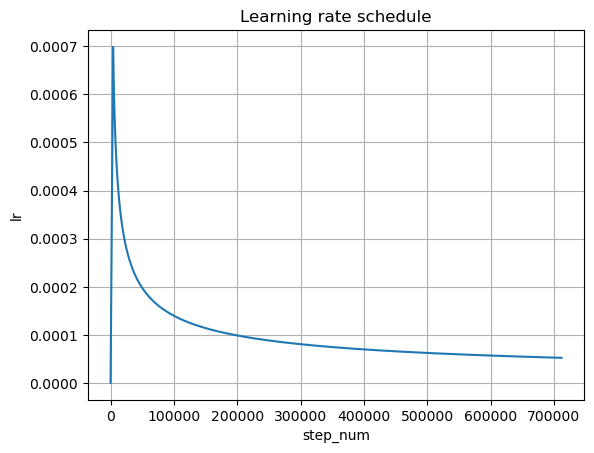

LR: start=1.746928107421711e-07, end=5.2375450022065523e-05


In [36]:
import numpy as np
import matplotlib.pyplot as plt

warmup_steps = 4000
num_steps_by_epoch = len(train_dataloader)
step_num = np.arange(1, EPOCHS*num_steps_by_epoch, 10)
step_num_exp = -0.5
warmup_steps_exp = -1.5
dim_embedding_exp = -0.5
lr = np.power(dim_embedding, dim_embedding_exp) * np.minimum(np.power(step_num, step_num_exp), step_num * np.power(warmup_steps, warmup_steps_exp))

plt.plot(step_num, lr)
plt.grid()
plt.xlabel('step_num')
plt.ylabel('lr')
plt.title('Learning rate schedule')
plt.show()
print(f"LR: start={lr[0]}, end={lr[-1]}")

Tiene mucho tiempo valores muy altor de learning rate, por lo que vamos a cambiar el warm up a 400 y el exponente de $d_{model}$ a -0.93. Con lo que el learning rate evolucionaría así

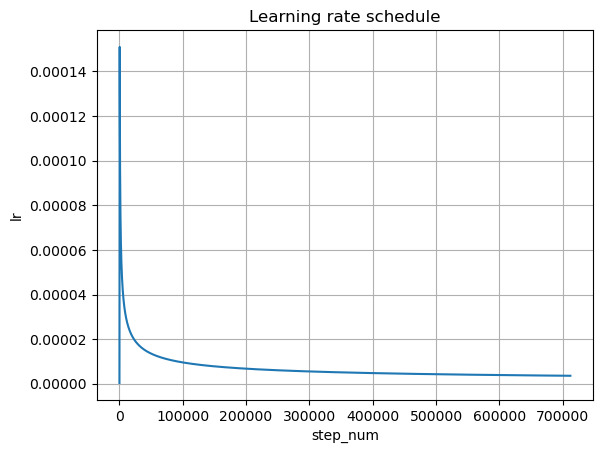

LR: start=3.778234847515599e-07, lr[100000]=9.558214331582429e-06, end=3.582132816240184e-06


In [37]:
warmup_steps = 400
num_steps_by_epoch = len(train_dataloader)
step_num = np.arange(1, EPOCHS*num_steps_by_epoch, 10)
step_num_exp = -0.5
warmup_steps_exp = -1.5
dim_embedding_exp = -0.93
lr = np.power(dim_embedding, dim_embedding_exp) * np.minimum(np.power(step_num, step_num_exp), step_num * np.power(warmup_steps, warmup_steps_exp))

plt.plot(step_num, lr)
plt.grid()
plt.xlabel('step_num')
plt.ylabel('lr')
plt.title('Learning rate schedule')
plt.show()
if SUBSET:
    lr_100000 = lr[1000]
else:
    lr_100000 = lr[10000]
print(f"LR: start={lr[0]}, lr[100000]={lr_100000}, end={lr[-1]}")

In [38]:
import numpy as np

def calculate_lr(step_num, dim_embeding_model=512, warmup_steps=4000):
    step_num += 1e-7 # Avoid division by zero
    step_num += STEP0
    actual_step.set_step(step_num)
    step_num_exp = -0.5
    warmup_steps_exp = -1.5
    dim_embeding_model_exp = -0.93
    lr = np.power(dim_embeding_model, dim_embeding_model_exp) * np.minimum(np.power(step_num, step_num_exp), step_num * np.power(warmup_steps, warmup_steps_exp))
    actual_lr.set_lr(lr)
    return lr

lr_lambda = lambda step: calculate_lr(step, dim_embeding_model=dim_embedding, warmup_steps=400)
if LR_SCHEDULER:
    lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

### Validation loop

In [39]:
def greedy_decode(model, source, tokenizer_tgt, max_len, device, bs):
    # Retrieving the indices from the start and end of sequences of the target tokens
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')    # Start of Sentence token index (2)
    # eos_idx = tokenizer_tgt.token_to_id('[EOS]')    # End of Sentence token index (3)

    # Computing the output of the encoder for the source sequence
    encoder_output = model.encode(source)
    
    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(bs,1).fill_(sos_idx).type_as(source).to(device)
    
    # Looping until the 'max_len', maximum length, is reached
    while True:
        if decoder_input.size(1) == max_len:
            break
            
        # Building a mask for the decoder input
        decoder_mask = create_mask(decoder_input.size(1)).to(device)
        
        # Calculating the output of the decoder
        out = model.decode(encoder_output, decoder_input, decoder_mask)
        
        # Applying the projection layer to get the probabilities for the next token
        prob = model.projection(out[:, -1])

        # Selecting token with the highest probability
        _, next_word = torch.max(prob, dim=1)
        # decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)
        decoder_input = torch.cat([decoder_input, next_word.unsqueeze(1)], dim=1)
    
    if len(decoder_input.shape) == 1:
        decoder_input = decoder_input.unsqueeze(0)
    elif len(decoder_input.shape) == 3:
        decoder_input = decoder_input.squeeze(0)

    return decoder_input # Sequence of tokens generated by the decoder


In [40]:
# from tqdm import tqdm
from fastprogress.fastprogress import progress_bar

import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

def validation_loop(model, validation_dataloader, tokenizer_tgt, max_len, device, master_bar):
    model.eval() # Setting model to evaluation mode

    # Calculating the number of batches in the validation dataset
    dataset_size = len(validation_dataloader.dataset)  # Tamaño total del conjunto de datos
    batch_size = validation_dataloader.batch_size      # Tamaño del batch
    drop_last = validation_dataloader.drop_last        # Configuración de drop_last
    num_batches = len(validation_dataloader)           # Número total de batches

    # Calculating the total number of samples in the validation dataset
    total_samples = batch_size * (num_batches - 1) + min(batch_size, dataset_size % batch_size)

    # If drop_last is False and the dataset size is not divisible by the batch size, we need to add one more batch
    if drop_last and dataset_size % batch_size != 0:
        total_samples -= dataset_size % batch_size

    # Initializing progress bar
    # progress_bar_ = tqdm(range(total_samples), desc = 'Processing validation examples') # Initializing progress bar
    progress_validation_bar = progress_bar(validation_dataloader, parent=master_bar)

    # Initializing lists to store scores
    bleu_scores = []
    meteor_scores = []
    
    # Creating evaluation loop
    with torch.no_grad(): # Ensuring that no gradients are computed during this process
        for batch in progress_validation_bar:
        # for batch in validation_dataloader:
            # Loading input data and masks onto the GPU
            encoder_input = batch['encoder_input'].to(device)
            
            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            num_samples = len(batch['src_text'])
            model_out_bs = greedy_decode(model, encoder_input, tokenizer_tgt, max_len, device, num_samples)

            # Get metrics for every example in the batch
            for i in range(num_samples):
                source_text = batch['src_text'][i]
                target_text = batch['tgt_text'][i]
                model_out_i = model_out_bs[i]
                model_out_text = tokenizer_tgt.decode(model_out_i.detach().cpu().numpy())

                # Calculating metrics
                references = [target_text.split()]
                hypothesis = model_out_text.split()
                bleu_score = sentence_bleu(references, hypothesis)
                meteor_score_value = meteor_score(references, hypothesis)
            
                # Appending scores to lists
                bleu_scores.append(bleu_score)
                meteor_scores.append(meteor_score_value)

                # Calculating mean scores            
                mean_bleu_score = sum(bleu_scores)/len(bleu_scores) # Calculating mean BLEU score
                mean_meteor_score = sum(meteor_scores)/len(meteor_scores) # Calculating mean METEOR score

                # Updating progress bar and printing bleu and meteor scores
                # progress_bar_.update(1)
                # progress_bar_.set_postfix({'BLEU': f'{mean_bleu_score:.9f}', 'METEOR': f'{mean_meteor_score:.9f}'})
                master_bar.child.comment = f'BLEU: {mean_bleu_score:.9f}, METEOR: {mean_meteor_score:.9f}'

    # Printing results
    # console_width = 80 # Fixed witdh for printed messages
    # print('-'*console_width)
    # print(f'SOURCE: {source_text}')
    # print(f'TARGET: {target_text}')
    # print(f'PREDICTED: {model_out_text}')
    # print('-'*console_width)

    return mean_bleu_score, mean_meteor_score, source_text, target_text, model_out_text


### Train loop

In [41]:
from fastprogress.fastprogress import progress_bar

def train_loop(model, train_dataloader, device, tokenizer_target, loss_fn, optimizer, master_bar, lr_scheduler=None):
    # Initializing an iterator over the training dataloader
    # We also use tqdm to display a progress bar
    # batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch:02d}')
    progress_train_bar = progress_bar(train_dataloader, parent=master_bar)
    
    # For each batch...
    # for batch in batch_iterator:
    for batch in progress_train_bar:
        model.train() # Train the model
            
        # Loading input data and masks onto the GPU
        encoder_input = batch['encoder_input'].to(device)
        decoder_input = batch['decoder_input'].to(device)
        decoder_mask = create_mask(decoder_input.size(1)).to(device)
        
        # Running tensors through the Transformer
        proj_output = model(encoder_input, decoder_input, decoder_mask)
        
        # Loading the target labels onto the GPU
        label = batch['label'].to(device)
        
        # Computing loss between model's output and true labels
        loss = loss_fn(proj_output.view(-1, tokenizer_target.get_vocab_size()), label.view(-1))
        
        # Updating progress bar, print loss and lr
        # batch_iterator.set_postfix({'loss': f'{loss.item():.6f}', 'lr': f'{actual_lr.get_lr():.9f}'})
        if loss.item() < 1e-5:
            loss_string = f'{loss.item():e}'
        elif loss.item() == 0:
            loss_string = '0'
        else:
            loss_string = f'{loss.item():.6f}'
        if actual_lr.get_lr() < 1e-5:
            actual_lr_string = f'{actual_lr.get_lr():e}'
        elif actual_lr.get_lr() == 0:
            actual_lr_string = '0'
        else:
            actual_lr_string = f'{actual_lr.get_lr():.9f}'
        master_bar.child.comment = f'loss: {loss_string}, lr: {actual_lr_string}'
        
        # Performing backpropagation
        loss.backward()
        
        # Updating parameters based on the gradients
        optimizer.step()
        
        # Clearing the gradients to prepare for the next batch
        optimizer.zero_grad()

        # Update step and LR
        if LR_SCHEDULER:
            lr_scheduler.step()
        
    return loss.item(), actual_lr.get_lr()

### Train preliminary

In [42]:
import time

def elapsed_time(t0):
    t = time.time() - t0  # tiempo transcurrido en segundos

    # Convertir el tiempo a días, horas, minutos y segundos
    days, t = divmod(t, 86400)  # 86400 segundos en un día
    hours, t = divmod(t, 3600)  # 3600 segundos en una hora
    minutes, seconds = divmod(t, 60)  # 60 segundos en un minuto

    return int(days), int(hours), int(minutes), int(seconds)

def elapsed_seconds(days, hours, minutes, seconds):
    return days * 86400 + hours * 3600 + minutes * 60 + seconds


In [43]:
if EPOCH0 != 0 or STEP0 != 0:
    weights = f"{MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth"
    print(f"Loading model from {weights}")
    if GPUS > 1:
        model.load_state_dict(torch.load(weights))
    else:
        model = torch.load(weights, map_location=device)
        if isinstance(model, nn.DataParallel):
            print("Transforming model from data parallel to model")
            model = model.module
    print(f"Model loaded from {weights}")

    validation_file_path = f"{MODEL_PATH}/best_validation_bleu_{EPOCH0}_{STEP0}.npy"
    print(f"load best validation loss from {validation_file_path}")
    best_bleu = np.load(validation_file_path)
    print(f"best validation meteor: {best_bleu}")
else:
    best_bleu = 1e-20

print(f"Starting training from epoch {EPOCH0} and step {STEP0}, best bleu: {best_bleu}")


Starting training from epoch 0 and step 0, best bleu: 1e-20


In [44]:
train_loss_list = []
train_lr_list = []
validation_meteor_list = []
validation_bleu_list = []

train_loss_list = np.array(train_loss_list)
train_lr_list = np.array(train_lr_list)
validation_meteor_list = np.array(validation_meteor_list)
validation_bleu_list = np.array(validation_bleu_list)

In [45]:
def plot_train(epoch, epochs, mb, train_loss, valid_meteor, valid_bleu):
    x = range(epoch)
    y = np.concatenate((train_loss, valid_meteor))
    graphs = [[x,train_loss], [x,valid_meteor]]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [1-x_margin, epochs+x_margin]
    y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

    mb.update_graph(graphs, x_bounds, y_bounds)

### Train

In [46]:
from fastprogress.fastprogress import master_bar

max_seconds = 60*60*11 + 60*30 # 11 horas y 30 minutos
t0 = time.time()

master_progress_bar = master_bar(range(EPOCH0, EPOCHS))

for epoch in master_progress_bar:
    days, hours, minutes, seconds = elapsed_time(t0)
    # print(f"\t Epoch {epoch} -------------------------------, {days} days, {hours} hours, {minutes} minutes, {seconds} seconds")

    # We run the 'train_loop' function at the beginning of each epoch
    if LR_SCHEDULER:
        train_loss, train_lr = train_loop(model, train_dataloader, device, tokenizer_target, loss_fn, optimizer, master_progress_bar, lr_scheduler)    
    else:
        train_loss, train_lr = train_loop(model, train_dataloader, device, tokenizer_target, loss_fn, optimizer, master_progress_bar)
        
    # We run the 'run_validation' function at the end of each epoch
    # to evaluate model performance
    validation_meteor, validation_bleu, validation_source_text, validation_target_text, validation_model_out_text = validation_loop(model, validation_dataloader, tokenizer_target, max_sequence_len, device, master_progress_bar)

    train_loss_list = np.append(train_loss_list, train_loss)
    train_lr_list = np.append(train_lr_list, train_lr)
    validation_meteor_list = np.append(validation_meteor_list, validation_meteor)
    validation_bleu_list = np.append(validation_bleu_list, validation_bleu)

    best_validation_belu_string = None
    if (validation_bleu > best_bleu) and SAVE_BEST_MODEL:
        best_bleu = validation_bleu
        weights = f"{MODEL_PATH}/transformer_{epoch}_{actual_step.get_step()}.pth"
        # print(f"Saving model to {weights}")
        if GPUS > 1:
            torch.save(model.state_dict(), weights)
        else:
            torch.save(model, weights)
        # print(f"Model saved to {weights}")

        best_bleu_path = f"{MODEL_PATH}/best_validation_bleu_{epoch}_{actual_step.get_step()}.npy"
        # print(f"Saving best validation meteor to {best_bleu_path}")
        np.save(best_bleu_path, best_bleu)
        # print(f"Best validation meteor saved to {best_bleu_path}")
        best_validation_belu_string = f"best validation bleu: {best_bleu} at epoch {epoch}"
    
    days, hours, minutes, seconds = elapsed_time(t0)
    elapsed_time_string = f"Elapsed time: {days} days, {hours} hours, {minutes} minutes, {seconds} seconds"
    if (elapsed_seconds(days, hours, minutes, seconds) > max_seconds) and STOP_AT_TIME:
        print(f"Elapsed time: {days} days, {hours} hours, {minutes} minutes, {seconds} seconds")
        break

    if best_validation_belu_string:
        master_progress_bar_string = f"Epoch {epoch} ----- train loss: {train_loss}, validation meteor: {validation_meteor}, validation bleu: {validation_bleu} ----- {best_validation_belu_string} ----- {elapsed_time_string}"
    else:
        master_progress_bar_string = f"Epoch {epoch} ----- train loss: {train_loss}, validation meteor: {validation_meteor}, validation bleu: {validation_bleu} ----- {elapsed_time_string}"
    master_progress_bar_string += f" ----- SOURCE: {validation_source_text} ----- TARGET: {validation_target_text} ----- PREDICTED: {validation_model_out_text}"
    master_progress_bar.main_bar.comment = master_progress_bar_string
    # master_progress_bar.write(master_progress_bar_string)

    # plot_train
    # (
    #     epoch, EPOCHS, 
    #     master_progress_bar,
    #     train_loss_list, validation_meteor_list, validation_bleu_list,
    # )

print("Done")

Done


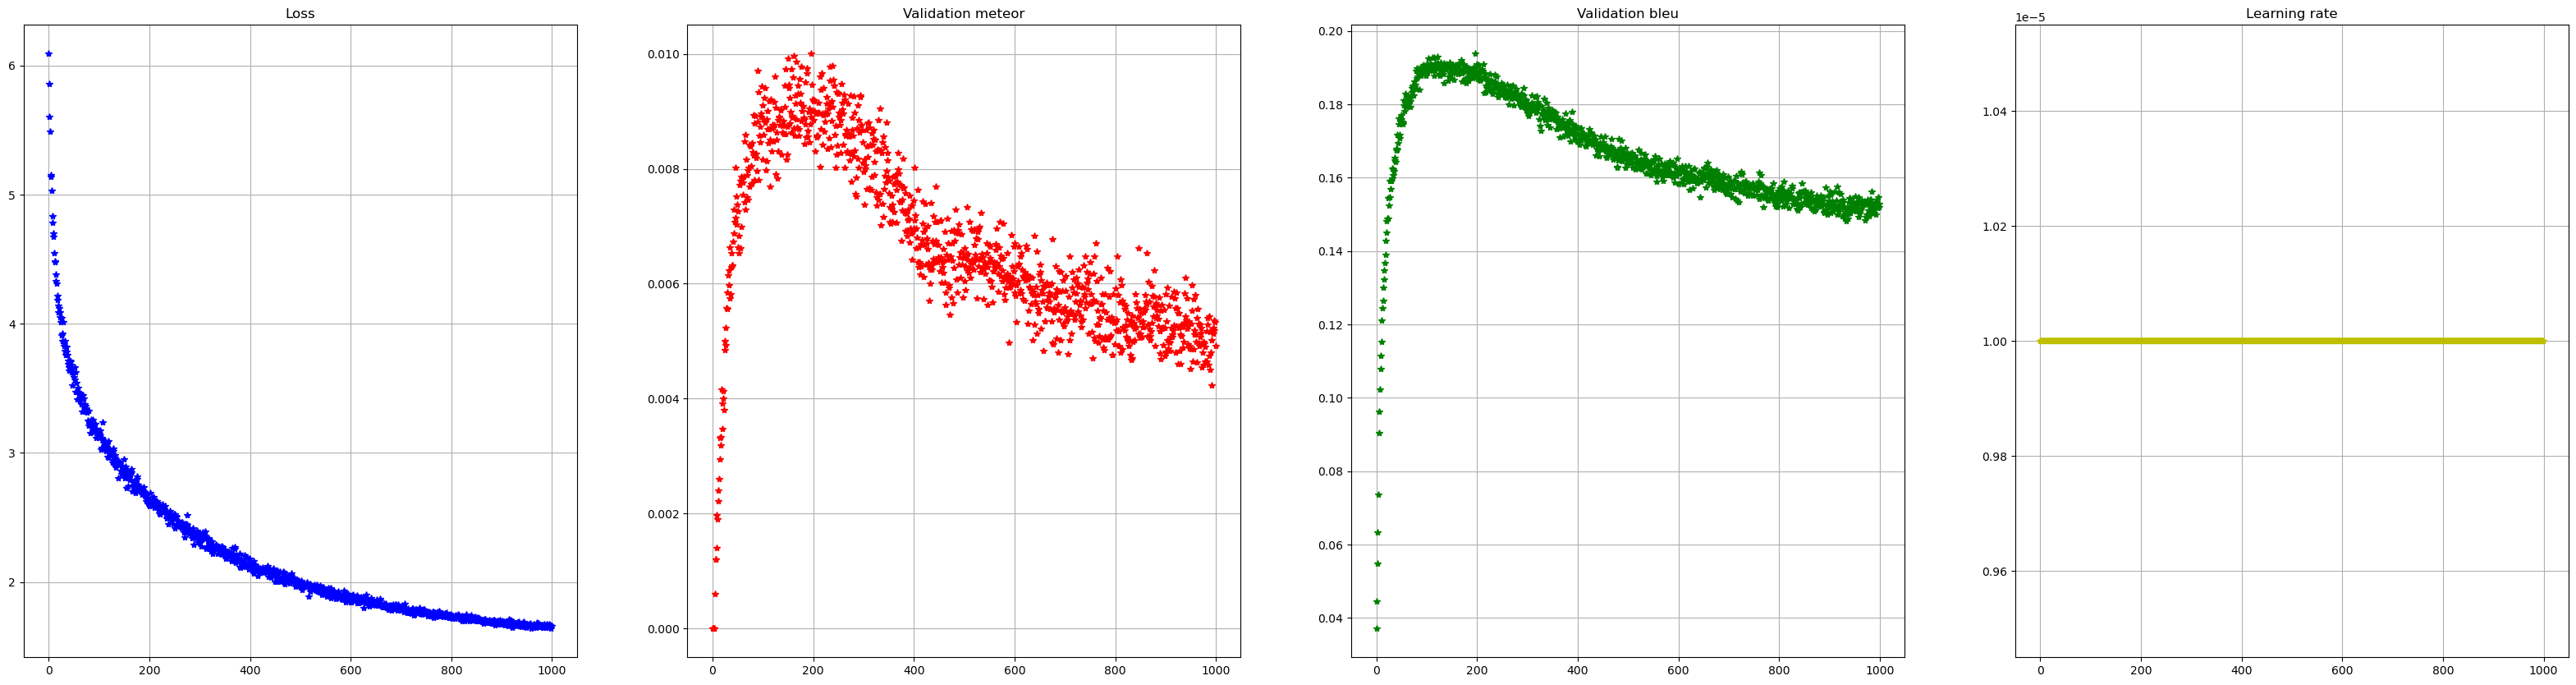

In [47]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(40, 10))
axs[0].plot(train_loss_list, 'b*')
axs[0].grid()
axs[0].set_title("Loss")
axs[1].plot(validation_meteor_list, 'r*')
axs[1].grid()
axs[1].set_title("Validation meteor")
axs[2].plot(validation_bleu_list, 'g*')
axs[2].grid()
axs[2].set_title("Validation bleu")
axs[3].plot(train_lr_list, 'y*')
axs[3].grid()
axs[3].set_title("Learning rate")
plt.show()